In [1]:
import numpy as np
import matplotlib.pyplot as plt
from funky import *

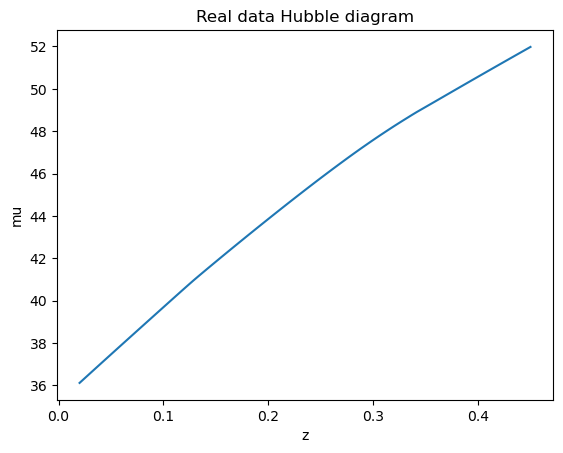

In [22]:
# Estrazione mu e z per dati reali. Alla fine verrà una smooth curve su una 
# griglia uniforme di z.
z_data,mu_data=get_hubble_real()
# summary statistic of real data
z_data,mu_data=(smoother(z_data,mu_data))


plt.plot(z_data,mu_data)
plt.title('Real data Hubble diagram')
plt.xlabel('z')
plt.ylabel('mu')
plt.show()

In [ ]:
# errore si deve aggiornare a ogni trial
# observed data: nel paper sono 200 sampled SNe con omega m =0.27 e w = -1. Ho=72 km s-1 mpc-1.
N=500    
T=500
t=1
w=np.repeat(1/N,repeats=N)
theta_1=[]
distances=[]

#iterazione t = 1
while len(theta_1)<N:

    # Sample from prior: uniform over 0 < omega < 1, -3 < w < 0.
    theta=np.array([rng.uniform(0,1), rng.uniform(-3,0)])

    # simulate z and mu given choice of theta
    z_1, mu_1= get_hubble_sim(theta)
    # create summary statistics
    _,mu_1=(smoother(z_1,mu_1))
    # compute delta from summary stat. of real data
    delta = np.median(np.abs(mu_data - mu_1))

    # build array
    theta_1.append(theta)
    distances.append(delta)
# final array of 500 particles to perturb.    
theta_t=np.array(theta_1)       

# TAU
tau_square=2*np.cov(theta_t, rowvar=True)

In [ ]:
epsilon_t = np.percentile(distances,q=0.75)

#for t in range(2,T):
while epsilon_t > 0.033:
    theta_new=[] # diventerà il nuovo theta_t
    weights_new=[] # diventeranno il nuovo w
    distances=[]

    # Voglio N particles che mi piacciono. Alla fine aggiornerò pesi e epsilon
    for i in range(N):
        while True:
            # sample particle
            idx=rng.choice(range(theta_t),p=w)
            theta_star=theta_t[idx]
            #perturb particle!
            theta_i_t=rng.multivariate_normal(theta_star, tau_square) # propongo un aggiornamento di un theta
            
            # simulate z and mu given choice of theta
            z_i_t, mu_i_t= get_hubble_sim(theta_i_t)
            # create summary statistics
            _,mu_i_t=smoother(z_i_t,mu_i_t)

            # compute distance from summary stat. of real data
            delta = np.median(np.abs(mu_data - mu_i_t))
            
            if delta<epsilon_t:
                break  #Ho trovato una particle che mi piace.
                   
        theta_new.append(theta_i_t)
        distances.append(delta)

        # aggiorna pesi ---- DA RICONTROLLARE
        denom = np.sum(
            w[j] * rng.multivariate_normal.pdf(theta_i_t, theta_t[j], tau_square)
            for j in range(N)
        )
        weight = rng.prior_pdf(theta_i_t) / denom
        weights_new.append(weight)


    ### Ora ho N particles che mi piacciono. Aggiorno tutto

    # w update
    weights_new=np.array(weights_new)
    w = weights_new / np.sum(weights_new)

    # theta_t update
    theta_t=np.array(theta_new)
    
    #epsilon update
    epsilon_t= np.quantile(distances,p=0.50)

# è finita. Ho il mio vettore theta di 500 particelle che seguono la posterior.
tau_square=2*np.cov(theta_t.T,aweights=w,bias=False)

TypeError: only integer scalar arrays can be converted to a scalar index

## TRASH

In [ ]:
#### simulazione dummy di z_phot, z_spec per 1744 SNe

z_spec=rng.uniform(0,0.45,size=1744)
z_phot=z_spec+ rng.normal(0.001,0.05,size=1744)
z_phot[z_phot<0]=0.001
z_phot[z_phot>0.45]=0.45
plt.scatter(z_spec,z_phot,c='orange')
plt.xlabel('spec z')
plt.ylabel('photo z')
plt.show()

In [ ]:
# snana per simulare sets di supernovae da diverse cosmologie.

#
# collezione di  500 particelle, viene migrata nel corso dell'algoritmo.
# poi scelgo a random una particella e la perturbo. Simulation data: 200 (z,z') pairs, sampling
# with replacement, da collezione di 500 particelle sopra. Con 200 true redshifts e theta i specificato
# allora calcoliamo il modulo di distanza. Aggiungiamo incertezza usando una Gaussian PDF con sigma= 0.04.
# gli observable data comprise the xti that appear nell'algoritmo. #

# summary statistic: applico un nonparametric regression smoother (5b), check appendice


# real data: per ogni curva, prendiamo 7 punti, prendiamo 103 sne sdss.
# simulated data: selection cuts e misuro il distance modulus.

# similarity delta: facciamo smooth dei due datasets e poi la median absolute deviation.
# fissiamo H0 a 65
# epsilon t: varia da iterazione a iterazione
# scegliamo N=150 particles e facciamo runnare il codice.




# Praticamente (z,z') mi serve solo nel primo esempio finto. 
# Mentre nell'altro caso, quello che vogliamo fare noi, penso lo faccia SNANA di simularsi un 
# redshift dalla power law.#

#            idx_z=rng.choice(range(z_phot),size=200,replace=True)
#            z_spec_i=z_spec[idx]
#            z_phot_i=z_phot[idx]
